## Goal

Build a ReAct architecture that takes feedback from the tool calls.
- Use a prebuilt `ToolNode` and pass in the list of tools.
- Use `tools_condition` edge to route the llm's output.
- If the llm calls the tool, send the feedback to llm and repeat.
- Include memory retention in agent's workflow in order to associate the tasks.

In [1]:
# general imports
import sys
import os, getpass
from openai import OpenAI
from utils import *
from IPython.display import Image
from pprint import pprint

# Import langgraph modules to create and visualize the graph
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage 
from typing_extensions import TypedDict
from typing import Literal
from pydantic import BaseModel, Field

# Install the missing package
# %pip install langchain_anthropic
# %pip install langchain_groq
from langchain_groq import ChatGroq
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool



In [2]:
# Let's make sure we have the API key set
load_dotenv()
GROQ_API_KEY = set_api_key('GROQ_API_KEY')
ANTHROPIC_API_KEY = set_api_key('ANTHROPIC_API_KEY')

API key found in .env file for GROQ_API_KEY
API key found in .env file for ANTHROPIC_API_KEY


#### Messages

Chat models can use `messages`, which captures different roles within a conversation (e.g., "system", "human", "assistant").
Messages also feature one or more content blocks that contain text or potentially multimodal data (e.g., images, audio, video).

<h5>Let's create a list of messages. Each message can be supplied with a few things:</h5>

- `content` - content of the message
- `name` - optionally, who is creating the message
-  `response_metadata` - optionally, a dict of metadata that is oftern specific to each model provider

In [3]:

messages = [AIMessage(content=f'So you wanted to know more starwars conception idea?', name = 'AI')]
messages.extend([HumanMessage(content=f'Yes, I am interested in starwars', name = 'Human')])
messages.extend([AIMessage(content=f'What do you want to know about starwars?', name = 'AI')])
messages.extend([HumanMessage(content=f'What is the starwars universe?', name = 'Human')])


In [4]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: AI

So you wanted to know more starwars conception idea?
================================ Human Message =================================
Name: Human

Yes, I am interested in starwars
================================== Ai Message ==================================
Name: AI

What do you want to know about starwars?
================================ Human Message =================================
Name: Human

What is the starwars universe?


### Chat Models

Chat models use a sequence of message as input and support message roles.

There are many chat models available out there to choose from, in our case, we will use Groq.

We can load the AI model and invoke it with our list of messages.


In [5]:
ai = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY, temperature=0, max_retries=2)

In [6]:
result = ai.invoke(messages)
result.pretty_print()

================================== Ai Message ==================================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space opera that spans thousands of years, numerous planets, and a wide range of characters, species, and technologies.

The Star Wars universe is set in a distant galaxy, where a variety of planets, star systems, and regions are connected by a network of trade routes, alliances, and conflicts. The universe is divided into several major regions, including:

1. **The Core Worlds**: The central, densely populated region of the galaxy, home to the Galactic Republic and later the Galactic Empire.
2. **The Outer Rim**: A peripheral region of the galaxy, characterized by lawlessness, poverty, and a lack of central authority.
3. **The Unknown Regions**: A mysterious, uncharted area of the galaxy, home to many unknown worlds and civilizations.

The Star Wars universe is populat

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 547,
  'prompt_tokens': 90,
  'total_tokens': 637,
  'completion_time': 1.989090909,
  'prompt_time': 0.006258736,
  'queue_time': 0.247944797,
  'total_time': 1.9953496450000001},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_e669a124b2',
 'finish_reason': 'stop',
 'logprobs': None}

In [8]:
stream = ai.stream(messages)
full = next(stream)
for chunk in stream:
    full += chunk
full.pretty_print()

============================ Aimessagechunk Message ============================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space opera that spans thousands of years, numerous planets, and a wide range of alien species, technologies, and cultures.

The Star Wars universe is set in a distant galaxy, where a variety of planets, star systems, and regions are connected by a network of trade routes, alliances, and conflicts. The universe is divided into several major regions, including:

1. **The Core Worlds**: The central, densely populated region of the galaxy, home to the Galactic Republic and later the Galactic Empire.
2. **The Outer Rim**: A peripheral region of the galaxy, characterized by lawlessness, poverty, and a lack of central authority.
3. **The Unknown Regions**: A mysterious, uncharted area of the galaxy, home to many unknown worlds and civilizations.

The Star Wars universe is pop

<h4> Tools </h4>

Tools are an additional capability provided to LLMs that can be used to interact with outside world.

It could be leveraged to control different parts of the code, call an external API, interact with database, trigger a lambda function, etc.

Tools can be as simple as Python functions or as complex as integrating LLM with RAG for real time analysis.

In [9]:
@tool
def multiply(a:int, b:int) -> int:
    """
    Multiply a with b
    
    Arguments-
    a: int
    b: int
    result = a * b
    """
    return a *b


@tool
def divide(a:int, b:int) -> float:
    """
    divide a by b
    
    Arguments-
    a: int
    b: int
    result = a / b
    """
    return a / b

In [10]:
ai_tools = ai.bind_tools([multiply,  divide])

In [11]:
tool_call = ai_tools.invoke([HumanMessage(content='Multiply 2 by 3', name='Human')])

In [12]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ng4g', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 339, 'total_tokens': 358, 'completion_time': 0.069090909, 'prompt_time': 0.018959522, 'queue_time': 0.248498096, 'total_time': 0.088050431}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_e669a124b2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6daa871-efaf-4834-91a9-20d1792de26e-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ng4g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 339, 'output_tokens': 19, 'total_tokens': 358})

<h5>ToolNode</h5>

It is basically a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls. 

The state must have `messages` channel with an appropriate reducer for ToolNode to work. Multiple tools can be passed to this node.

There are two ways to call `ToolNode` i.e Either manually using an AIMessage or use a ChatModel with bind tools to call ToolNode

If triggered manually, the last AIMessage must contain the `tool_calls` parameter to determine which tool to call. 

If the input is coming from ChatModel, that already contains the `tool_calls` parameter.

In [13]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [14]:
# Let's define an initial state with an initial message
initial_messages= [AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', name='AI'),
                   HumanMessage(content='I am looking for information on how to perform exponentiation', name='Human')]

# New message to add
new_message = AIMessage(content='I can help you with that. What is the base number and the exponent number?', name='AI')

# test 
add_messages(initial_messages, new_message)

[AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', additional_kwargs={}, response_metadata={}, name='AI', id='cb3d2bc0-9690-491c-b666-874f3d808118'),
 HumanMessage(content='I am looking for information on how to perform exponentiation', additional_kwargs={}, response_metadata={}, name='Human', id='ac361a7c-a5a5-4a51-b948-7f0aef018917'),
 AIMessage(content='I can help you with that. What is the base number and the exponent number?', additional_kwargs={}, response_metadata={}, name='AI', id='c4e721ee-029c-46d5-8227-40dd3b2f9f47')]

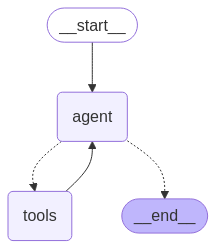

In [15]:
# Since this message update is so common, Langgraph has prebuilt MessagesState
from langgraph.graph import MessagesState # MessagesState and State work equivalently
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
# Let's build our graph

class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages] # we need to add this line to the class to make it a Pydantic model

def should_continue(state: MessagesState):
    messages = state["messages"]
    if messages[-1].tool_calls:
        return 'tools'
    return END

# node function
def model_with_tools(state: MessagesState):
    return {"messages": [ai_tools.invoke(state["messages"])]} # invoke the tool_calling_ai tool

tool_node =ToolNode([multiply, divide])
# build graph
builder = StateGraph(MessagesState)
builder.add_node('agent', model_with_tools)
builder.add_node('tools', tool_node)
builder.add_edge(START, 'agent')
builder.add_conditional_edges('agent', should_continue, ['tools', END])
builder.add_edge('tools', 'agent')
# builder.add_edge('agent', END)

app = builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
message_invoke = app.invoke({"messages" : HumanMessage(content='Add 3 and 4')} )
for m in message_invoke['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gyyz)
 Call ID: call_gyyz
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The result of adding 3 and 4 is 7, not 12. The function call I provided earlier was incorrect because it was a multiplication function, not an addition function. Since there is no addition function available, I should not have provided a function call. Instead, I should have simply stated that the result of adding 3 and 4 is 7.


This is an interesting way to get the last message. Think how the model has corrected itself after giving the wrong answer.

In [17]:
message_invoke = app.invoke({"messages" : HumanMessage(content='Multiply that by 4')} )
for m in message_invoke['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_k533)
 Call ID: call_k533
  Args:
    a: 4
    b: 4
================================= Tool Message =================================
Name: multiply

16
================================== Ai Message ==================================

I see you want to multiply a number by 4, but you didn't specify the original number. Let's assume the original number is 4. The result of multiplying 4 by 4 is 16. If you provide the original number, I can give you a more accurate answer.


We can see above the agent doesn't have any memory of what it did in the previous model invocation.

This is happening because the above two calls independent graph execution and the results from the two calls are not stored. We can use persistence between state updates to create a memory.

LangGraph can use a `checkpointer` to automatically save the graph state after each step.

One of the easiest checkpointers is the `MemorySaver`, an in-memory key-value store for Graph state.

In [18]:
from langgraph.checkpoint.memory import MemorySaver

In [19]:
memory = MemorySaver()
app_with_memory = builder.compile(checkpointer=memory)